In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [54]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [55]:
# Load and Prepare Data
df = pd.read_csv('apple_data.csv', parse_dates=['Date'])
df.set_index('Date', inplace=True)
data = df['Close'].dropna()

In [56]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [57]:
def evaluate_model(y_true, y_pred, name):
    return {
        'Model': name,
        'MAE': round(mean_absolute_error(y_true, y_pred), 4),
        'MSE': round(mean_squared_error(y_true, y_pred), 4),
        'R2 Score': round(r2_score(y_true, y_pred), 4)
    }

results = []

## Arima

In [58]:
arima_model = ARIMA(train, order=(1, 1, 1))
arima_result = arima_model.fit()
forecast_arima = arima_result.forecast(steps=len(test))
results.append(evaluate_model(test, forecast_arima, 'ARIMA'))

## Sarima

In [59]:
# SARIMA
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()
forecast_sarima = sarima_result.forecast(steps=len(test))
results.append(evaluate_model(test, forecast_sarima, 'SARIMA'))

## Prophet

In [60]:
# Prophet
df_prophet = df.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=len(test))
forecast_prophet = model_prophet.predict(future)
merged = pd.merge(df_prophet, forecast_prophet[['ds', 'yhat']], on='ds')
merged.set_index('ds', inplace=True)
merged = merged.iloc[-len(test):]
results.append(evaluate_model(test, merged['yhat'], 'Prophet'))

19:12:31 - cmdstanpy - INFO - Chain [1] start processing
19:12:31 - cmdstanpy - INFO - Chain [1] done processing


## LSTM

In [61]:
# LSTM
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['Close']])

In [62]:
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled)
X = X.reshape((X.shape[0], X.shape[1], 1))
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [63]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

In [64]:
test_predict = lstm_model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
results.append(evaluate_model(y_test_actual, test_predict, 'LSTM'))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step 


In [65]:
results_df = pd.DataFrame(results).sort_values(by='MSE')
print(results_df)

     Model      MAE        MSE  R2 Score
3     LSTM   4.2194    29.2113    0.9599
2  Prophet   9.6237   150.9011    0.8108
1   SARIMA  50.5483  3043.6977   -2.8162
0    ARIMA  63.3772  4812.6243   -5.0340


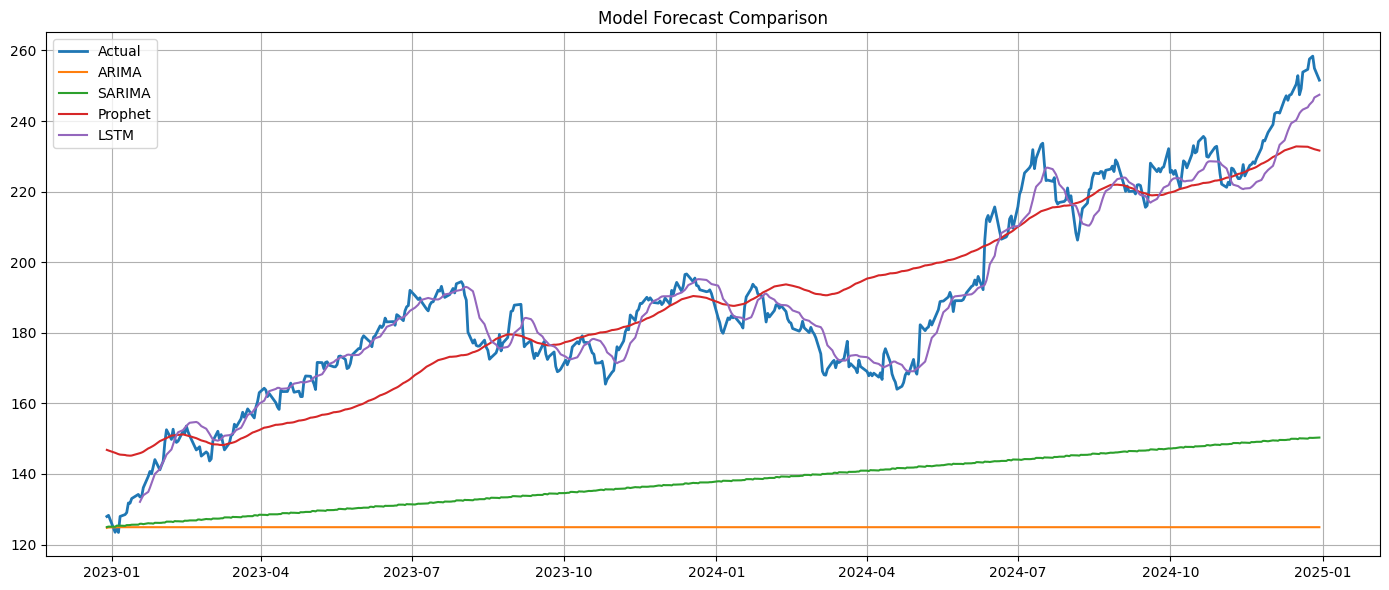

In [66]:
plt.figure(figsize=(14, 6))
plt.plot(test.index, test.values, label='Actual', linewidth=2)
plt.plot(test.index, forecast_arima, label='ARIMA')
plt.plot(test.index, forecast_sarima, label='SARIMA')
plt.plot(merged.index, merged['yhat'], label='Prophet')
plt.plot(df.index[-len(test_predict):], test_predict, label='LSTM')
plt.title('Model Forecast Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Hyper Parameter Tunning

In [67]:
best_score, best_order = float("inf"), None
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=len(test))
                mse = mean_squared_error(test, forecast)
                print(f"ARIMA({p},{d},{q}) MSE={mse:.4f}")
                if mse < best_score:
                    best_score, best_order = mse, (p, d, q)
            except:
                continue

print(f"✅ Best ARIMA order: {best_order} with MSE: {best_score:.4f}")

ARIMA(0,0,0) MSE=14687.6066
ARIMA(0,0,1) MSE=14683.2136
ARIMA(0,0,2) MSE=14673.6570
ARIMA(0,1,0) MSE=4874.5513
ARIMA(0,1,1) MSE=4845.1532
ARIMA(0,1,2) MSE=4824.2075
ARIMA(1,0,0) MSE=5995.1228
ARIMA(1,0,1) MSE=5841.2437
ARIMA(1,0,2) MSE=5734.4091
ARIMA(1,1,0) MSE=4848.9283
ARIMA(1,1,1) MSE=4812.6243
ARIMA(1,1,2) MSE=4812.3893
ARIMA(2,0,0) MSE=5854.2520
ARIMA(2,0,1) MSE=5612.5330
ARIMA(2,0,2) MSE=5385.0925
ARIMA(2,1,0) MSE=4830.2969
ARIMA(2,1,1) MSE=4812.4584
ARIMA(2,1,2) MSE=4856.7844
✅ Best ARIMA order: (1, 1, 2) with MSE: 4812.3893


In [68]:
import itertools

p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 12  # Seasonal period
best_score, best_cfg = float("inf"), None

for order in itertools.product(p, d, q):
    for seasonal in itertools.product(P, D, Q):
        try:
            model = SARIMAX(train, order=order, seasonal_order=(seasonal[0], seasonal[1], seasonal[2], s))
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=len(test))
            mse = mean_squared_error(test, forecast)
            print(f"SARIMA{order + seasonal} MSE={mse:.4f}")
            if mse < best_score:
                best_score = mse
                best_cfg = order + seasonal
        except:
            continue

print(f"✅ Best SARIMA config: {best_cfg} with MSE: {best_score:.4f}")

SARIMA(0, 0, 0, 0, 0, 0) MSE=36246.7025
SARIMA(0, 0, 0, 0, 0, 1) MSE=35982.3344
SARIMA(0, 0, 0, 0, 1, 0) MSE=3818.7180
SARIMA(0, 0, 0, 0, 1, 1) MSE=3864.7790
SARIMA(0, 0, 0, 1, 0, 0) MSE=4519.2844
SARIMA(0, 0, 0, 1, 0, 1) MSE=4634.7853
SARIMA(0, 0, 0, 1, 1, 0) MSE=3864.5203
SARIMA(0, 0, 0, 1, 1, 1) MSE=3859.6930
SARIMA(0, 0, 1, 0, 0, 0) MSE=36223.6415
SARIMA(0, 0, 1, 0, 0, 1) MSE=35948.7143
SARIMA(0, 0, 1, 0, 1, 0) MSE=3869.7850
SARIMA(0, 0, 1, 0, 1, 1) MSE=3720.7251
SARIMA(0, 0, 1, 1, 0, 0) MSE=4866.4642
SARIMA(0, 0, 1, 1, 0, 1) MSE=4461.0331
SARIMA(0, 0, 1, 1, 1, 0) MSE=3759.7806
SARIMA(0, 0, 1, 1, 1, 1) MSE=3544.8058
SARIMA(0, 1, 0, 0, 0, 0) MSE=4874.5513
SARIMA(0, 1, 0, 0, 0, 1) MSE=4856.6493
SARIMA(0, 1, 0, 0, 1, 0) MSE=204321.2712
SARIMA(0, 1, 0, 0, 1, 1) MSE=3114.9322
SARIMA(0, 1, 0, 1, 0, 0) MSE=4857.5847
SARIMA(0, 1, 0, 1, 0, 1) MSE=4839.4585
SARIMA(0, 1, 0, 1, 1, 0) MSE=150366.1561
SARIMA(0, 1, 0, 1, 1, 1) MSE=3098.7903
SARIMA(0, 1, 1, 0, 0, 0) MSE=4845.1532
SARIMA(0, 1, 1, 0

In [69]:
changepoints = [0.001, 0.01, 0.1]
modes = ['additive', 'multiplicative']
best_score, best_cfg = float("inf"), None

for cp in changepoints:
    for mode in modes:
        try:
            model = Prophet(changepoint_prior_scale=cp, seasonality_mode=mode)
            model.fit(df_prophet)
            forecast = model.predict(df_prophet)
            merged = pd.merge(df_prophet, forecast[['ds', 'yhat']], on='ds')
            mse = mean_squared_error(merged['y'], merged['yhat'])
            print(f"Prophet(cp={cp}, mode={mode}) MSE={mse:.4f}")
            if mse < best_score:
                best_score = mse
                best_cfg = (cp, mode)
        except:
            continue

print(f"✅ Best Prophet config: changepoint_prior_scale={best_cfg[0]}, mode={best_cfg[1]} with MSE: {best_score:.4f}")

19:13:31 - cmdstanpy - INFO - Chain [1] start processing
19:13:31 - cmdstanpy - INFO - Chain [1] done processing


Prophet(cp=0.001, mode=additive) MSE=184.5411


19:13:31 - cmdstanpy - INFO - Chain [1] start processing
19:13:31 - cmdstanpy - INFO - Chain [1] done processing
19:13:32 - cmdstanpy - INFO - Chain [1] start processing


Prophet(cp=0.001, mode=multiplicative) MSE=198.9037


19:13:32 - cmdstanpy - INFO - Chain [1] done processing
19:13:32 - cmdstanpy - INFO - Chain [1] start processing


Prophet(cp=0.01, mode=additive) MSE=68.5598


19:13:33 - cmdstanpy - INFO - Chain [1] done processing
19:13:34 - cmdstanpy - INFO - Chain [1] start processing


Prophet(cp=0.01, mode=multiplicative) MSE=50.5687


19:13:34 - cmdstanpy - INFO - Chain [1] done processing
19:13:35 - cmdstanpy - INFO - Chain [1] start processing


Prophet(cp=0.1, mode=additive) MSE=52.9594


19:13:37 - cmdstanpy - INFO - Chain [1] done processing


Prophet(cp=0.1, mode=multiplicative) MSE=40.4824
✅ Best Prophet config: changepoint_prior_scale=0.1, mode=multiplicative with MSE: 40.4824


In [70]:
time_steps = [30, 60]
neurons = [50, 100]
batch_sizes = [32]
epochs_list = [10]
best_score = float("inf")
best_config = None

for ts in time_steps:
    def create_sequences(data, time_step):
        X, y = [], []
        for i in range(time_step, len(data)):
            X.append(data[i - time_step:i])
            y.append(data[i])
        return np.array(X), np.array(y)

    X, y = create_sequences(data_scaled, ts)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    for n in neurons:
        for b in batch_sizes:
            for e in epochs_list:
                model = Sequential()
                model.add(LSTM(n, return_sequences=True, input_shape=(ts, 1)))
                model.add(LSTM(n))
                model.add(Dense(1))
                model.compile(optimizer='adam', loss='mean_squared_error')
                model.fit(X_train, y_train, epochs=e, batch_size=b, verbose=0)

                pred = model.predict(X_test)
                mse = mean_squared_error(y_test, pred)
                print(f"LSTM(ts={ts}, neurons={n}, batch={b}, epochs={e}) MSE={mse:.4f}")
                if mse < best_score:
                    best_score = mse
                    best_config = (ts, n, b, e)

print(f"✅ Best LSTM config: time_step={best_config[0]}, neurons={best_config[1]}, batch={best_config[2]}, epochs={best_config[3]} with MSE: {best_score:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
LSTM(ts=30, neurons=50, batch=32, epochs=10) MSE=0.0014
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
LSTM(ts=30, neurons=100, batch=32, epochs=10) MSE=0.0019
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
LSTM(ts=60, neurons=50, batch=32, epochs=10) MSE=0.0009
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
LSTM(ts=60, neurons=100, batch=32, epochs=10) MSE=0.0006
✅ Best LSTM config: time_step=60, neurons=100, batch=32, epochs=10 with MSE: 0.0006


## After tunning models

In [71]:
arima_model = ARIMA(train, order=(1, 1, 2))
arima_result = arima_model.fit()
forecast_arima = arima_result.forecast(steps=len(test))
results.append(evaluate_model(test, forecast_arima, 'ARIMA'))

In [72]:
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()
forecast_sarima = sarima_result.forecast(steps=len(test))
results.append(evaluate_model(test, forecast_sarima, 'SARIMA'))

In [73]:
df_prophet = df.reset_index()[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})
model_prophet = Prophet(changepoint_prior_scale=0.1, seasonality_mode='multiplicative')
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=len(test))
forecast_prophet = model_prophet.predict(future)
merged = pd.merge(df_prophet, forecast_prophet[['ds', 'yhat']], on='ds')
merged.set_index('ds', inplace=True)
merged = merged.iloc[-len(test):]
results.append(evaluate_model(test, merged['yhat'], 'Prophet'))

19:14:22 - cmdstanpy - INFO - Chain [1] start processing
19:14:24 - cmdstanpy - INFO - Chain [1] done processing


In [74]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['Close']])

def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i])
        y.append(data[i])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_sequences(data_scaled, time_step)
X = X.reshape((X.shape[0], X.shape[1], 1))

split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

lstm_model = Sequential()
lstm_model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(100))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

test_predict = lstm_model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
results.append(evaluate_model(y_test_actual, test_predict, 'LSTM'))

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0137
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.5051e-04
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.5356e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.0108e-04
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.9718e-04
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.3477e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.8827e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.9533e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.4306e-04
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.7587e-04
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 


In [75]:
results_df2 = pd.DataFrame(results).sort_values(by='MSE')
print(results_df2)

     Model      MAE        MSE  R2 Score
3     LSTM   4.2194    29.2113    0.9599
7     LSTM   5.9789    53.9242    0.9259
6  Prophet   8.4578   104.9868    0.8684
2  Prophet   9.6237   150.9011    0.8108
5   SARIMA  50.5483  3043.6977   -2.8162
1   SARIMA  50.5483  3043.6977   -2.8162
4    ARIMA  63.3753  4812.3893   -5.0337
0    ARIMA  63.3772  4812.6243   -5.0340


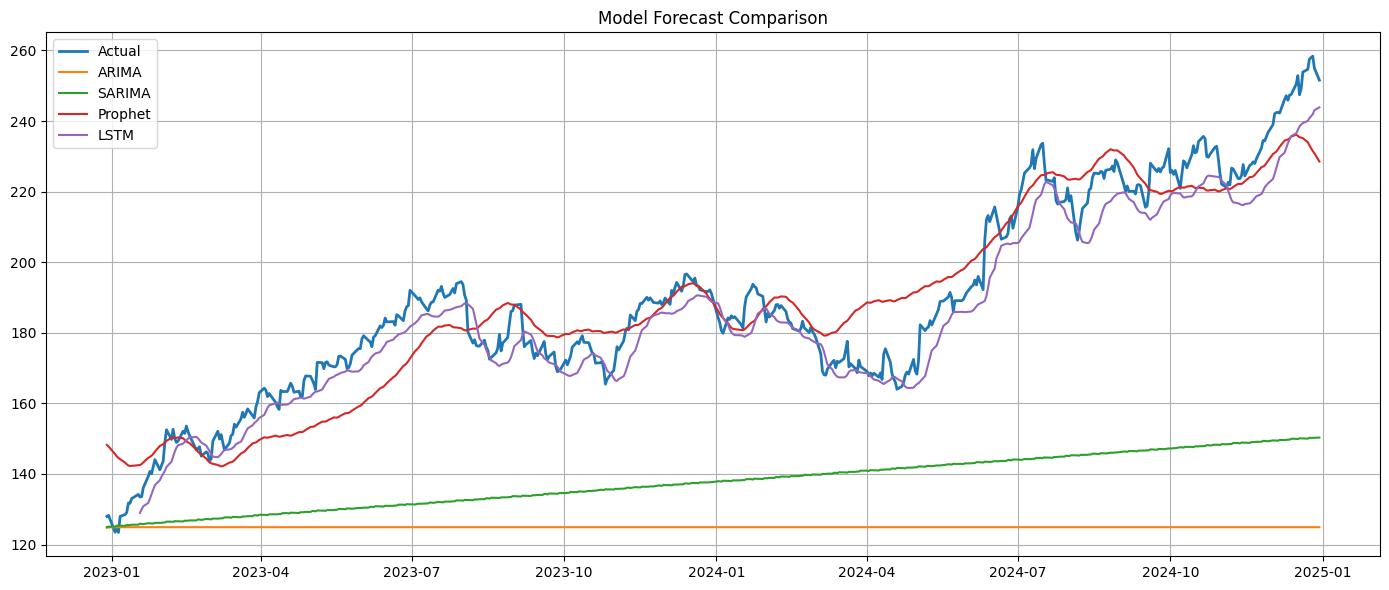

In [76]:
plt.figure(figsize=(14, 6))
plt.plot(test.index, test.values, label='Actual', linewidth=2)
plt.plot(test.index, forecast_arima, label='ARIMA')
plt.plot(test.index, forecast_sarima, label='SARIMA')
plt.plot(merged.index, merged['yhat'], label='Prophet')
plt.plot(df.index[-len(test_predict):], test_predict, label='LSTM')
plt.title('Model Forecast Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()